In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, SpatialDropout1D, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

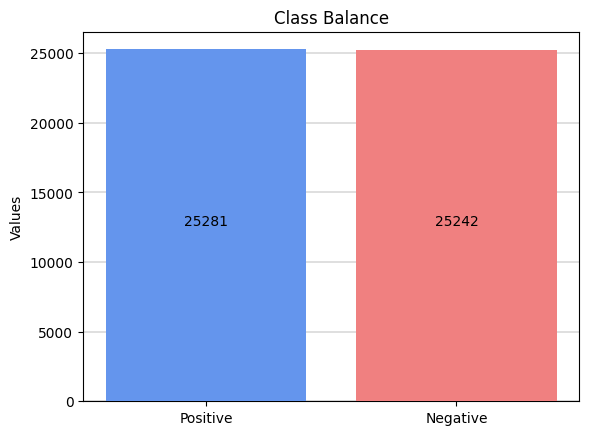

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [17]:
# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=15000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [18]:
#Split data 80% data train and 20% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(40418, 3445) (40418,)
(10105, 3445) (10105,)


In [19]:
tf_idf_len

3445

In [20]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [21]:
x_train.shape

(40418, 3445, 1)

In [22]:
y_train.shape

(40418,)

In [23]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Menentukan model CNN
def cnn(x_train, y_train, x_test, y_test):

    model = Sequential()
    model.add(Input(shape=(tf_idf_len, 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    optimizer = Adam(learning_rate=0.001)
    print(model.summary())
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])


    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_3                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7171 - loss: 0.5024 - val_accuracy: 0.8257 - val_loss: 0.3705
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7742 - loss: 0.4051 - val_accuracy: 0.8228 - val_loss: 0.3829
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7914 - loss: 0.3754 - val_accuracy: 0.8267 - val_loss: 0.3523
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8076 - loss: 0.3443 - val_accuracy: 0.8212 - val_loss: 0.3652
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8190 - loss: 0.3227 - val_accuracy: 0.8147 - val_loss: 0.3716
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8251 - loss: 0.3064 - val_accuracy: 0.8073 - val_loss: 0.3910


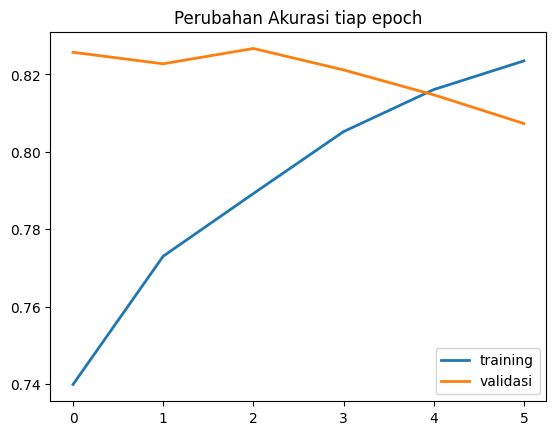

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.791150  0.829600  0.809919      5000
           1   0.824763  0.785504  0.804655      5105

    accuracy                       0.807323     10105
   macro avg   0.807957  0.807552  0.807287     10105
weighted avg   0.808131  0.807323  0.807260     10105



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_4                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7173 - loss: 0.5057 - val_accuracy: 0.8138 - val_loss: 0.4047
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7680 - loss: 0.4146 - val_accuracy: 0.8312 - val_loss: 0.3563
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7813 - loss: 0.3821 - val_accuracy: 0.8272 - val_loss: 0.3643
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7998 - loss: 0.3611 - val_accuracy: 0.8321 - val_loss: 0.3526
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8142 - loss: 0.3370 - val_accuracy: 0.8250 - val_loss: 0.3649
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8214 - loss: 0.3233 - val_accuracy: 0.8190 - val_loss: 0.3832
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8289 - loss: 0.3045 - val_accuracy: 0.8183 - val_loss: 0.3781


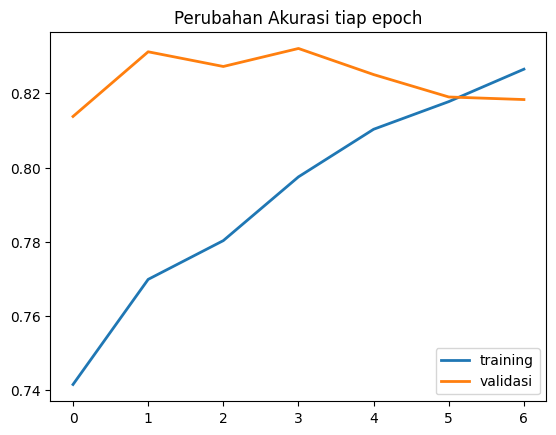

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.809347  0.827800  0.818469      5000
           1   0.827489  0.809011  0.818146      5105

    accuracy                       0.818308     10105
   macro avg   0.818418  0.818405  0.818308     10105
weighted avg   0.818512  0.818308  0.818306     10105



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_5                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,953 (26.88 MB)

 Trainable params: 7,045,953 (26.88 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7221 - loss: 0.5057 - val_accuracy: 0.8143 - val_loss: 0.3799
Epoch 2/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7681 - loss: 0.4146 - val_accuracy: 0.8171 - val_loss: 0.3824
Epoch 3/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7848 - loss: 0.3812 - val_accuracy: 0.8226 - val_loss: 0.3658
Epoch 4/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7974 - loss: 0.3602 - val_accuracy: 0.8324 - val_loss: 0.3478
Epoch 5/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8055 - loss: 0.3475 - val_accuracy: 0.8247 - val_loss: 0.3648
Epoch 6/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8150 - loss: 0.3211 - val_accuracy: 0.8264 - val_loss: 0.3693
Epoch 7/10
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8270 - loss: 0.3022 - val_accuracy: 0.8260 - val_loss: 0.3728


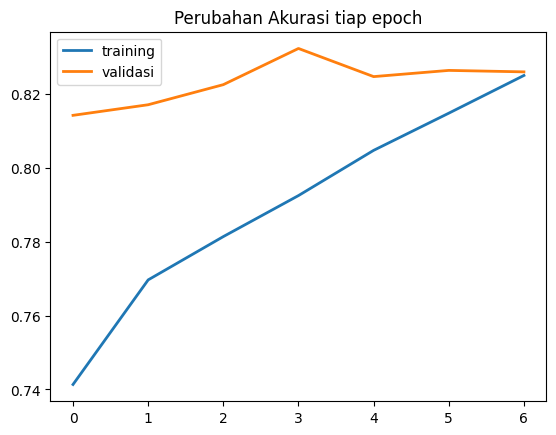

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.820609  0.829800  0.825179      5000
           1   0.831452  0.822331  0.826866      5105

    accuracy                       0.826027     10105
   macro avg   0.826030  0.826066  0.826023     10105
weighted avg   0.826087  0.826027  0.826031     10105



In [25]:
result = []
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))
result.append(cnn(x_train, y_train, x_test, y_test))

In [26]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8172191984166254
Average Precision : 0.8279015751721523
Average Recall    : 0.8056154097290239
Average F1-Score  : 0.8165558075386614
